<a href="https://colab.research.google.com/github/igvasilev/study-projects/blob/master/Project_Author_attribution1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *MLDM Project*


## Task: “Authorship attribution”

## Team:
### 1.	Vasilev Igor
### 2.	Eric George Parakal


### Program description:

**Description**:  the program analyzes statistical characteristics of given texts and classify sentences by authors 

**Data**: the dataset consist of labeled sentences of the following authors
1.	А.П. Чехов "Палата №6", ''Степь', 'Дуэль'
2.	Н.В. Гоголь "Вий", 'Мертвые души'
3.	А.С. Пушкин "Дубровский", "Капитанская дочка", 'Повести покойного И.П.Белкина'
4.	Л.Н.Толстой "Детство", "Анна Каренина"
5.	И.С. Тургенев "Му-му", "Отцы и дети"

(Texts were manually downloaded here http://lib.ru)


**Roadmap**:
1.	Download and prepare dataset, provide summary statistic
2. Building classificator (such as SVM, Naive Bayes) based of Bag of Words model with TF-IDF normalization 
3.	Applying Word2vec, building classificator based on embeddedings 






In [0]:
# Morphoanalyzer of russian language
!pip install pymorphy2

In [0]:
# For plotting ROC-AUC
!pip install scikit-plot

## Librares and dependences 

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import random as rd
import matplotlib.pyplot as plt
import scikitplot as skplt
import pymorphy2
import string
import nltk
import os


from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from collections import Counter

from nltk import tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymystem3 import Mystem

import gensim 

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.initializers import Constant



%matplotlib inline

Using TensorFlow backend.


In [0]:
# Stopwords data
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# Punctuation
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## I. Bag of Words model

### Dataset preprocessing



Exclude sentences which length less than 12 chars. They are not give any usefull information. For the correct tokenization we use ru_punct library which is allow to work with difficult russian punctuation

In [0]:
!git clone https://github.com/Mottl/ru_punkt.git

Cloning into 'ru_punkt'...
remote: Enumerating objects: 39, done.
remote: Total 39 (delta 0), reused 0 (delta 0), pack-reused 39
Unpacking objects: 100% (39/39), done.


In [0]:
!cp -r ru_punkt/nltk_data ~/nltk_data

In [0]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:

tokenizer = nltk.data.load('nltk_data/tokenizers/punkt/russian.pickle')

In [0]:
# Tokenization example (splitting text into sentences)
text = "Ай да А.С. Пушкин! Ай да сукин сын!"
print(tokenizer.tokenize(text))

['Ай да А.С. Пушкин!', 'Ай да сукин сын!']


In [0]:

def text_tokenize(filepath, min_length):
  
  doc = ''
  with open(filepath, 'r', encoding='UTF-8') as f:
    
    doc = f.read().replace('\n', ' ')
    doc = doc.replace('.”', '”.')
    doc = doc.replace('."', '".')
    doc = doc.replace('?”', '”?')
    doc = doc.replace('!”', '”!')
    doc = doc.replace('--', ' ')
    doc = doc.replace('. . .', '')
    doc = doc.replace('_', '')
    doc = doc.replace('}', '')
    doc = doc.replace('{', '')
    
  
  sentences = tokenizer.tokenize(doc)
    
  sentences = [sent for sent in sentences if len(sent) >= min_length]

  return list(sentences)
    

#### Create lists of sentences for each author

In [0]:
# Minimal sentence length (in chars)
min_length = 12

chehov =   text_tokenize('Chehov.Palata_nomer_6.txt', min_length)\
         + text_tokenize('Chehov.Step.txt', min_length)\
         + text_tokenize('Chehov.Duel.txt', min_length)
gogol =    text_tokenize('Gogol.Vii.txt', min_length)\
         + text_tokenize('Gogol.Mertvie_dushi.txt', min_length)
pushkin =  text_tokenize('Pushkin.Dubrovsky.txt', min_length)\
         + text_tokenize('Pushkin.Kapitanskaya_dochka.txt', min_length)\
         + text_tokenize('Pushkin.Belkin.txt', min_length)
tolstoy =  text_tokenize('Tolstoy.Detstvo.txt', min_length)\
         + text_tokenize('Tolstoy.Anna_Karenina.txt', min_length)
turgenev = text_tokenize('Turgenev.MuMu.txt', min_length)\
         + text_tokenize('Turgenev.Otsy_i_dety.txt', min_length)

In [0]:
text_dict = {
    'Chehov': chehov,
    'Gogol': gogol,
    'Pushkin': pushkin,
    'Tolstoy': tolstoy,
    'Turgenev': turgenev
            }

# Number of sentences for each author
for key in text_dict.keys():
    print(key, ':', len(text_dict[key]))

Chehov : 5308
Gogol : 5246
Pushkin : 5962
Tolstoy : 20658
Turgenev : 4774




We will take 4500 random sentences for each author to make our classes balanced

#### Choosing sentences

In [0]:
np.random.seed(42)

# Number of sentences
max_len = 4500

# List of authors
authors = [chehov, gogol, pushkin, tolstoy, turgenev]
combined = []

# Choose 4500 random sentences
for name in authors:
    name = np.random.choice(name, max_len, replace = False)
    
    text = []
    s = ''
    count = 0
    for i in name:
      s += ' ' + i
      count += 1
      if count == 1:
        text.append(s)
        count = 0
        s = ''
        
    combined += list(text)

print('Total number of texts:', len(combined))

Total number of texts: 22500


####  Create list with labels which corresponds to author sentences

In [0]:
max_len = int(max_len)
labels = ['Chehov']*max_len + ['Gogol']*max_len + ['Pushkin']*max_len\
       + ['Tolstoy']*max_len + ['Turgenev']*max_len 

print('The letght of the list with labels:', len(labels))

The letght of the list with labels: 22500


#### Final dataset

In [0]:
# Combine labels with sentences and mix it
zipped = list(zip(combined, labels))
rd.shuffle(zipped)
combined, labels = zip(*zipped)


df = pd.DataFrame()
df['sentence'] = combined
df['author'] = labels

print(df.head())

                                            sentence   author
0   А живет он второе лето в этом вонючем городиш...   Chehov
1   Вдруг она услыхала ровный и спокойный носовой...  Tolstoy
2                              "Послушайте, матушка.    Gogol
3           Казалось, он думал, глядя на него: "Эге!    Gogol
4                                     - повторил он.  Pushkin


In [0]:
# Create CSV file
df.to_csv('russian_authors_12.csv', index=False)

### Overview and data processing

In [0]:
# Download dataset
data = pd.read_csv("russian_authors_12.csv", encoding="UTF-8")
print(data.head())

                                            sentence   author
0   А живет он второе лето в этом вонючем городиш...   Chehov
1   Вдруг она услыхала ровный и спокойный носовой...  Tolstoy
2                              "Послушайте, матушка.    Gogol
3           Казалось, он думал, глядя на него: "Эге!    Gogol
4                                     - повторил он.  Pushkin


In [0]:
sent = list(data['sentence'].values)
authors = list(data['author'].values)

print("The dataset consists of {} sentences.".format(len(sent)))

The dataset consists of 22500 sentences.


In [0]:
# Distribution of sentences
Counter(authors)

Counter({'Chehov': 4500,
         'Gogol': 4500,
         'Pushkin': 4500,
         'Tolstoy': 4500,
         'Turgenev': 4500})

### Dataset statistics

In [0]:
# Tokenizer
tok = RegexpTokenizer(r'\w+')


In [0]:
# lists of number of words/chars in each sentence
word_count = []
char_count = []

for i in range(len(sent)):
    word_count.append(len(tok.tokenize(sent[i])))
    char_count.append(len(sent[i]))


word_count = np.array(word_count)
char_count = np.array(char_count)

# Average word length
av_length = np.array(char_count)/np.array(word_count)

In [0]:
df = data
df['word_count'] = word_count
df['Char_count'] = char_count
df['av_length'] = av_length
df.head()

,sentence,author,word_count,Char_count,av_length
0,А живет он второе лето в этом вонючем городиш...,Chehov,20,110,5.500000
1,Вдруг она услыхала ровный и спокойный носовой...,Tolstoy,8,53,6.625000
2,"""Послушайте, матушка.",Gogol,2,22,11.000000
3,"Казалось, он думал, глядя на него: ""Эге!",Gogol,7,41,5.857143
4,- повторил он.,Pushkin,2,15,7.500000


#### Common statistic on dataset

In [0]:
def stat(x):
  print('Min: ', np.min(x))
  print()
  print('Max: ', np.max(x))
  print()
  print('Mean:', np.mean(x))
  print()
  print('Median: ', np.median(x))  
  

In [0]:
# Number of words
stat(word_count)


Min:  1

Max:  199

Mean: 14.130755555555556

Median:  10.0


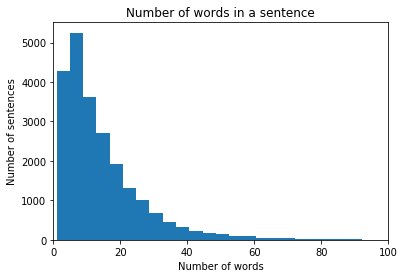

In [0]:
# Number of words distribution
plt.hist(word_count, bins = 50)
plt.title('Number of words in a sentence')
plt.xlabel('Number of words')
plt.ylabel('Number of sentences')
plt.xlim(0, 100)
plt.savefig("word_count.eps")

Word`s distribution corresponds to the Zipf law

In [0]:
# Sentence length
stat(char_count)

Min:  13

Max:  1266

Mean: 90.47533333333334

Median:  65.0


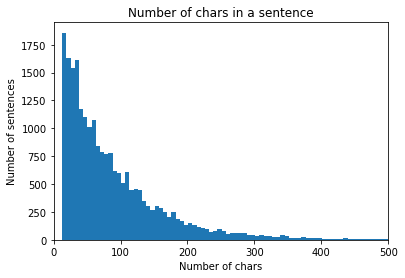

In [0]:
# Distribution of number of chars in sentence
plt.hist(char_count, bins = 200)
plt.title('Number of chars in a sentence')
plt.xlabel('Number of chars')
plt.ylabel('Number of sentences')
plt.xlim(0, 500)
plt.savefig("char_count.eps")

In [0]:
# Average word length
stat(av_length)

Min:  3.2

Max:  17.0

Mean: 6.535368076154129

Median:  6.4


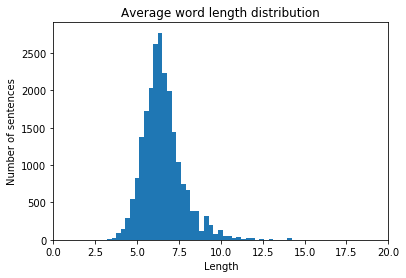

In [0]:
plt.hist(av_length, bins = 50)
plt.title('Average word length distribution')
plt.xlabel('Length')
plt.ylabel('Number of sentences')
plt.xlim(0, 20)
plt.savefig("av_length.eps")

It is distributed normally

In [0]:
# Statistics by letters
text_string = ''

for i in range(len(sent)):
    # Split sentences into words
    for s in tok.tokenize(sent[i]):
        s = s.lower() 
        text_string += s

# Letter distribution by sentences
char_cnt = Counter(text_string)
print(char_cnt)
print(len(char_cnt))

Counter({'о': 182031, 'е': 134539, 'а': 131834, 'и': 109516, 'н': 102611, 'т': 91935, 'с': 83088, 'л': 79773, 'в': 74068, 'р': 67124, 'к': 58573, 'д': 49677, 'м': 49566, 'у': 47334, 'п': 43345, 'я': 33784, 'ь': 31529, 'г': 29626, 'б': 29283, 'ы': 29087, 'ч': 27098, 'з': 27019, 'й': 17631, 'ж': 17015, 'ш': 14958, 'х': 13761, 'ю': 10066, 'ц': 5099, 'щ': 4368, 'э': 3608, 'ф': 2324, 'ё': 529, 'ъ': 476, 'e': 431, 'i': 415, 'a': 274, 'n': 249, 's': 207, 't': 200, 'r': 186, 'o': 178, 'm': 162, 'l': 146, 'u': 144, 'x': 126, 'v': 105, 'c': 101, 'd': 98, '1': 78, 'p': 66, '0': 65, 'h': 51, 'b': 49, '2': 45, 'f': 43, '3': 38, 'g': 36, '8': 34, '7': 32, '5': 28, '6': 22, '9': 19, 'z': 18, '4': 17, 'q': 16, 'k': 13, 'j': 11, 'y': 9, 'w': 7, 'é': 5, 'è': 2, 'à': 2, 'ѣ': 2, 'ê': 2, 'ó': 1, 'ç': 1})
76



We have noticed that some words are  foreign

In [0]:
# All chars list
print(list(char_cnt.keys()))

['а', 'ж', 'и', 'в', 'е', 'т', 'о', 'н', 'р', 'л', 'э', 'м', 'ю', 'ч', 'г', 'д', 'ш', 'к', 'п', 'у', 'б', 'ы', 'ь', 'с', 'х', 'й', 'з', 'я', 'ц', 'ё', 'щ', 'ф', 'ъ', 'n', 'o', '6', 'j', 'a', 'd', 'r', 'e', 'l', 'm', 'i', 's', 't', 'k', 'x', '5', 'b', 'p', 'u', 'z', 'v', 'g', '7', '3', '2', 'c', '1', '0', '8', '9', 'f', 'ó', 'q', 'y', 'h', 'w', 'è', '4', 'à', 'ç', 'é', 'ѣ', 'ê']


In [0]:
no_integers = [item for item in list(char_cnt.keys())[33:] if not item.isdigit()]
no_integers

['n',
 'o',
 'j',
 'a',
 'd',
 'r',
 'e',
 'l',
 'm',
 'i',
 's',
 't',
 'k',
 'x',
 'b',
 'p',
 'u',
 'z',
 'v',
 'g',
 'c',
 'f',
 'ó',
 'q',
 'y',
 'h',
 'w',
 'è',
 'à',
 'ç',
 'é',
 'ѣ',
 'ê']

In [0]:
# Foreign symbosl
#unusual_chars = ['v', 'i', 'e', 'a', 'n',
#                  'o','s', 'x', 'm', 't',
#                  'r', 'u', 'c', 'd', 'p',
#                 'h', 'f', 'b', 'g', 'q',
#                 'y', 'z', 'j', 'k', 'w',
#                 'é', 'ç', 'è', 'ê', 'à',
#                 'ѣ', 'ѳ', 'і' ]

unusual_chars = no_integers

# Sentences comprised foreign chars
unusual_text = []

for i in range(len(sent)):
    for j in sent[i]:
        if j in unusual_chars:
            unusual_text.append(i)
        
unusual_text = list(set(unusual_text))
 
print('The dataset comprice', str(len(unusual_text)), 'sentences with foreign words')

The dataset comprice 229 sentences with foreign words


In [0]:
# Sentences with unusual words
for i in unusual_text:
    print("Sentence {}".format(i))
    print(sent[i] + '\n')

Sentence 13824
 Он вынул платок, отер кровь, пощупал вокруг раны...   Кость цела,   бормотал он сквозь зубы,   пуля прошла неглубоко насквозь, один мускул, vastus externus, задет.

Sentence 15362
 Наконец он улыбнулся, поглядел вверх на небо и, кладя псалтирь в карман, сказал:      Fini!

Sentence 12291
 A bon entendeur, salut!

Sentence 1032
 (Марья Гавриловна  вспомнила  первое письмо  St.-Preux).

Sentence 7689
 О, этот Швабрин превеликий Schelm, и если попадется ко мне  в руки,  то я велю его  судить в  24  часа,  и мы расстреляем его  на парапете крепости!

Sentence 8200
 Elle fait sensation.

Sentence 12299
 Вот его нравственный остов: утром туфли, купанье и кофе, потом до обеда туфли, моцион и разговоры, в два часа туфли, обед и вино, в пять часов купанье, чай и вино, затем винт и лганье, и десять часов ужин и вино, а после полуночи сон и la femme женщина (франц.).. Существование его заключено в эту тесную программу, как яйцо в скорлупу.

Sentence 15373
 Например, mon amie моя п

#### Statistic by authors

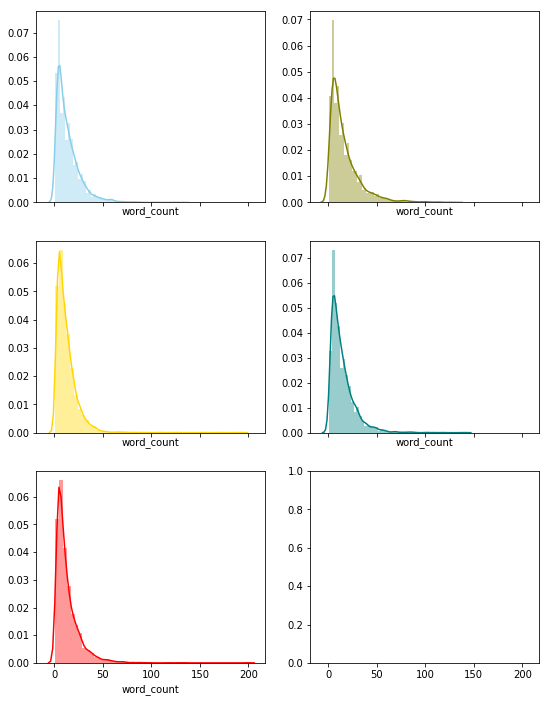

In [0]:
# Word_count in a sentence by author
f, axes = plt.subplots(3, 2, figsize=(9, 12), sharex=True)
sns.distplot( df[df["author"]=='Chehov']['word_count'] , color="skyblue", ax=axes[0, 0])
sns.distplot( df[df["author"]=='Gogol']['word_count'] , color="olive", ax=axes[0, 1])
sns.distplot( df[df["author"]=='Pushkin']['word_count'] , color="gold", ax=axes[1, 0])
sns.distplot( df[df["author"]=='Tolstoy']['word_count'] , color="teal", ax=axes[1, 1])
sns.distplot( df[df["author"]=='Turgenev']['word_count'] , color="r", ax=axes[2, 0])

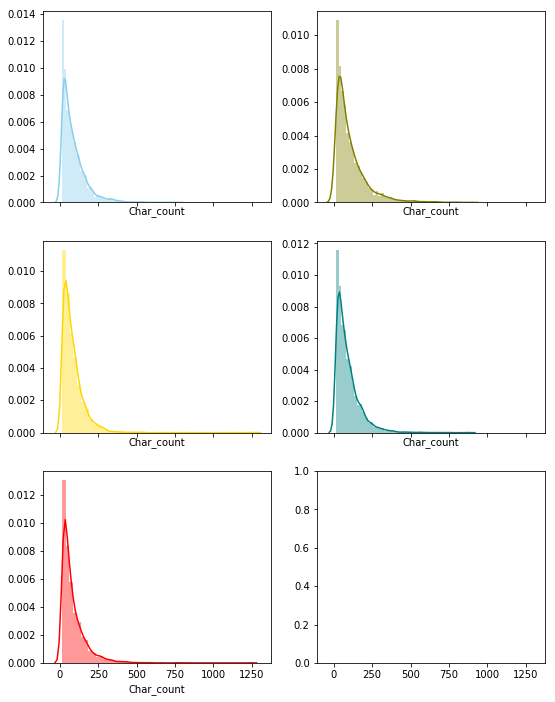

In [0]:
# Char_count in a sentence by author
f, axes = plt.subplots(3, 2, figsize=(9, 12), sharex=True)
sns.distplot( df[df["author"]=='Chehov']['Char_count'] , color="skyblue", ax=axes[0, 0], label='Chehov')
sns.distplot( df[df["author"]=='Gogol']['Char_count'] , color="olive", ax=axes[0, 1], label = 'Gogol')
sns.distplot( df[df["author"]=='Pushkin']['Char_count'] , color="gold", ax=axes[1, 0], label = 'Pushkin')
sns.distplot( df[df["author"]=='Tolstoy']['Char_count'] , color="teal", ax=axes[1, 1], label = 'Tolstoy')
sns.distplot( df[df["author"]=='Turgenev']['Char_count'] , color="r", ax=axes[2, 0], label = 'Turgenev')

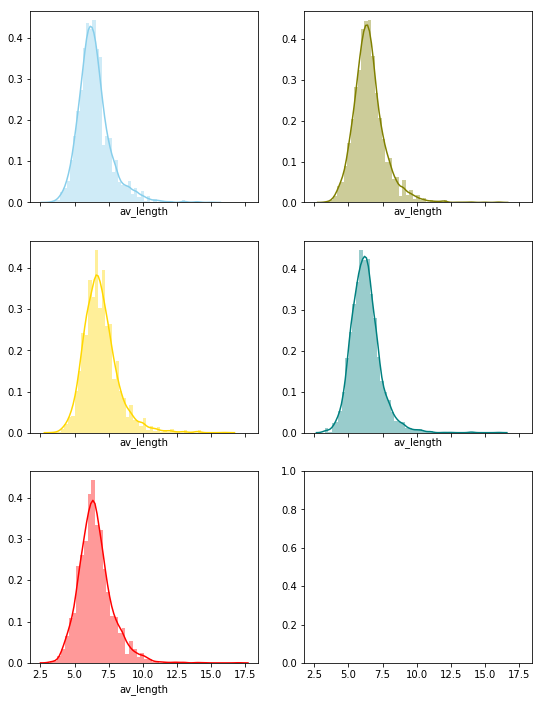

In [0]:
W# Average word length in a sentence by author
f, axes = plt.subplots(3, 2, figsize=(9, 12), sharex=True)
sns.distplot( df[df["author"]=='Chehov']['av_length'] , color="skyblue", ax=axes[0, 0])
sns.distplot( df[df["author"]=='Gogol']['av_length'] , color="olive", ax=axes[0, 1])
sns.distplot( df[df["author"]=='Pushkin']['av_length'] , color="gold", ax=axes[1, 0])
sns.distplot( df[df["author"]=='Tolstoy']['av_length'] , color="teal", ax=axes[1, 1])
sns.distplot( df[df["author"]=='Turgenev']['av_length'] , color="r", ax=axes[2, 0])

We don`t see significant difference in distribution, therefore we think that exctracting features from ordinary sentences is not a good idea here. Because sentences don`t have a stable unique structure in any case.

### Sentence normalization

In [0]:

# Delete all punctuation signs and lowercase all words
normed_sent = []

for i in range(len(sent)):
    s = sent[i].lower()
    s = s.translate(str.maketrans('','', string.punctuation))
    s = s.replace('“', '').replace('”', '')
    normed_sent.append(s)
    
print(normed_sent[0:3])    
print("Number of sentences: ", len(normed_sent))

[' а живет он второе лето в этом вонючем городишке потому что лучше быть первым в деревне чем в городе вторым', ' вдруг она услыхала ровный и спокойный носовой свист', ' послушайте матушка']
Number of sentences:  22500


### Spritting dataset on test and train 

In [0]:
sent_train, sent_test, authors_train, authors_test = train_test_split(normed_sent, authors, test_size = 0.2, random_state = 7)

In [0]:
pd.DataFrame({
    'Number of samples in train sentences data: ': np.shape(sent_train),
    'Number of samples in test sentences data': np.shape(sent_test),
    'Number of samples in train authors data': np.shape(authors_train),
    'Number of samples in test authors data': np.shape(authors_test)
})


,Number of samples in train sentences data:,Number of samples in test sentences data,Number of samples in train authors data,Number of samples in test authors data
0,18000,4500,18000,4500


### Stemming and stopwords exclusion (most common words which do not characterize texts)


In [0]:
# Russian stopwords
rus_stopwords = stopwords.words("russian")

# Lemmatizator
morph = pymorphy2.MorphAnalyzer()

In [0]:
def preprocess_text(text):
    
    processed = []
    
    for sent in text:
        
        processed_sent = []
       
        new = tok.tokenize(sent.lower())
        
        for w in new:
            if not w in rus_stopwords:
                # Lemmatization
                processed_sent.append(morph.parse(w)[0].normal_form) 
                
        processed_sent = " ".join(processed_sent)
        
        processed.append(processed_sent)
              
    return processed

In [0]:
# Preprocess train and test data
processed_train = preprocess_text(sent_train)
processed_test = preprocess_text(sent_test)

print(processed_train[0:5])

['подумать анна вспоминать взгляд вронский алексей александр', 'следовать примкнуть манилов', 'такой случай он пойти евгений василья познакомить ваш они ситниковый кирсан проворчать останавливаться базар', 'видеть славянофил', 'чтоть хотеть выразить заметить несколько зарапортоваться ковырнуть рука воздух продолжать деревня уединение иметь очень приятность']


### Creation of features-objects matrix



* We use here the "Bag of Words" model which take into account only number of particular words in each sentence

* Also we use TF-IDF measure to increase "weight" of words which mostly characterize for particular authors

In [0]:
# Parameters for TF-IDF,  min df = 6 (min document frequency - if a word
# occures more that 5 times we do not increase its weight)
vectorizer = TfidfVectorizer(min_df = 6) 
                             
vectorizer.fit(processed_train)

# Creation of feature-object matrix
words_train = vectorizer.transform(processed_train)
words_test = vectorizer.transform(processed_test)

###  Classification




#### First we try SVM model

In [0]:
svm = SVC()
params = {'kernel': ['linear', 'poly'], 'C':[1, 10, 100]}
scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(svm, params, scoring = scorer, verbose = 50)

In [0]:
np.random.seed(42)
word_svm = grid_obj.fit(words_train, authors_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.624, total=  17.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.2s remaining:    0.0s
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.616, total=  17.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   34.4s remaining:    0.0s
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.624, total=  17.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   51.7s remaining:    0.0s
[CV] C=1, kernel=poly ................................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .................... C=1, kernel=poly, score=0.201, total=  23.9s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s
[CV] C=1, kernel=poly ................................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .................... C=1, kernel=poly, score=0.201, total=  23.7s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s
[CV] C=1, kernel=poly ................................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .................... C=1, kernel=poly, score=0.201, total=  23.7s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.1min remaining:    0.0s
[CV] C=10, kernel=linear .............................................
[CV] ................. C=10, kernel=linear, score=0.579, total=  20.1s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.4min remaining:    0.0s
[CV] C=10, kernel=linear .............................................
[CV] ................. C=10, kernel=linear, score=0.582, total=  20.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.7min remaining:    0.0s
[CV] C=10, kernel=linear .............................................
[CV] ................. C=10, kernel=linear, score=0.581, total=  19.9s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.0min remaining:    0.0s
[CV] C=10, kernel=poly ...............................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] ................... C=10, kernel=poly, score=0.201, total=  23.9s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.4min remaining:    0.0s
[CV] C=10, kernel=poly ...............................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] ................... C=10, kernel=poly, score=0.201, total=  23.8s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:  3.8min remaining:    0.0s
[CV] C=10, kernel=poly ...............................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] ................... C=10, kernel=poly, score=0.201, total=  24.2s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  4.2min remaining:    0.0s
[CV] C=100, kernel=linear ............................................
[CV] ................ C=100, kernel=linear, score=0.549, total=  30.3s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:  4.8min remaining:    0.0s
[CV] C=100, kernel=linear ............................................
[CV] ................ C=100, kernel=linear, score=0.541, total=  29.9s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:  5.2min remaining:    0.0s
[CV] C=100, kernel=linear ............................................
[CV] ................ C=100, kernel=linear, score=0.554, total=  31.4s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  5.8min remaining:    0.0s
[CV] C=100, kernel=poly ..............................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .................. C=100, kernel=poly, score=0.201, total=  24.1s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  6.2min remaining:    0.0s
[CV] C=100, kernel=poly ..............................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .................. C=100, kernel=poly, score=0.201, total=  24.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:  6.6min remaining:    0.0s
[CV] C=100, kernel=poly ..............................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .................. C=100, kernel=poly, score=0.201, total=  24.1s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  7.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  7.0min finished


Best parameters: C=1, kernel = 'linear'

In [0]:
print(word_svm.best_estimator_)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


In [0]:
print('SVM gets best %s: %f with parameters: %s' % (str(scorer), word_svm.best_score_, str(word_svm.best_params_)))

SVM gets best make_scorer(accuracy_score): 0.621333 with parameters: {'C': 1, 'kernel': 'linear'}


#### Naive Bayes

In [0]:
# Naive Bayes
clf_params = {'alpha': np.linspace(0,1,10)}
             
clf = MultinomialNB()

# set scorer
scorer_ = make_scorer(accuracy_score)

# set CV parameters
cv = 5

# set GridSearch parameters
grcv = GridSearchCV(estimator=clf, 
                    param_grid=clf_params, 
                    scoring=scorer_, 
                    cv=cv, 
                    return_train_score=True, 
                    n_jobs=8, 
                    verbose=1)

# set Pipeline parameters
pipeline = Pipeline(steps=[('parameters tuning', grcv)])

# launch pipeline with scaling followed by cross-validation with parameters tuning
_ = pipeline.fit(words_train, authors_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    8.6s finished


In [0]:
print('NB classifier gets best %s: %f with parameters: %s' % (str(scorer_), grcv.best_score_, str(grcv.best_params_)))

NB classifier gets best make_scorer(accuracy_score): 0.657778 with parameters: {'alpha': 0.4444444444444444}


### Classification efficency evaluation


#### Bag of words, SVM



Accuracy: 0.6393333333333333
Average Precision: 0.6408093871636071
Average Recall: 0.6393333333333332
Average F1 Score: 0.6388723856112284

              precision    recall  f1-score   support

      Chehov       0.62      0.67      0.64       877
       Gogol       0.66      0.66      0.66       897
     Pushkin       0.62      0.67      0.64       883
     Tolstoy       0.64      0.63      0.63       913
    Turgenev       0.67      0.57      0.62       930

    accuracy                           0.64      4500
   macro avg       0.64      0.64      0.64      4500
weighted avg       0.64      0.64      0.64      4500




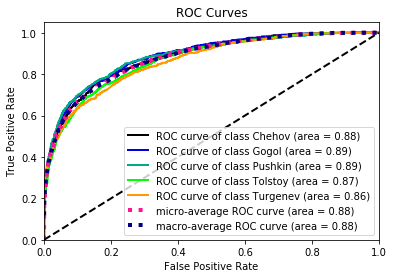

In [0]:
#(Bag of words SVM)
np.random.seed(89)


model = SVC(C = 1, kernel = 'linear',probability=True)
model.fit(words_train, authors_train)



authors_pred = model.predict(words_test)
authors_pred_proba = model.predict_proba(words_test)


accuracy = accuracy_score(authors_test, authors_pred)
precision, recall, f1, support = score(authors_test, authors_pred)
av_precision = np.average(precision, weights = support/np.sum(support))
av_recall = np.average(recall, weights = support/np.sum(support))
av_f1 = np.average(f1, weights = support/np.sum(support))

print("Accuracy:", accuracy)
print("Average Precision:", av_precision)
print("Average Recall:", av_recall)
print("Average F1 Score:", av_f1)
print()
print(classification_report(authors_test, authors_pred))
print()
#ROC-AUC
skplt.metrics.plot_roc(authors_test, authors_pred_proba)
plt.show()

#### Bag of words, Naive Bayes

Accuracy: 0.6506666666666666
Average Precision: 0.6525089037311259
Average Recall: 0.6506666666666667
Average F1 Score: 0.6506047582725807

              precision    recall  f1-score   support

      Chehov       0.62      0.68      0.65       877
       Gogol       0.66      0.68      0.67       897
     Pushkin       0.70      0.67      0.68       883
     Tolstoy       0.62      0.64      0.63       913
    Turgenev       0.67      0.59      0.63       930

    accuracy                           0.65      4500
   macro avg       0.65      0.65      0.65      4500
weighted avg       0.65      0.65      0.65      4500




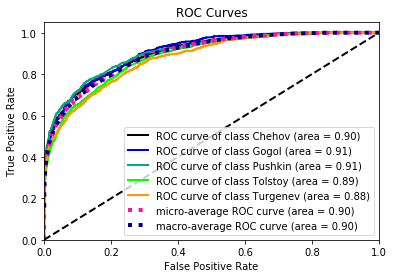

In [0]:
#(Bag of words NB)
np.random.seed(89)

model = MultinomialNB(alpha = 0.4444444444444444)
model.fit(words_train, authors_train)


authors_pred = model.predict(words_test)
authors_pred_proba = model.predict_proba(words_test)


accuracy = accuracy_score(authors_test, authors_pred)
precision, recall, f1, support = score(authors_test, authors_pred)
av_precision = np.average(precision, weights = support/np.sum(support))
av_recall = np.average(recall, weights = support/np.sum(support))
av_f1 = np.average(f1, weights = support/np.sum(support))

print("Accuracy:", accuracy)
print("Average Precision:", av_precision)
print("Average Recall:", av_recall)
print("Average F1 Score:", av_f1)
print()
print(classification_report(authors_test, authors_pred))
print()
#ROC-AUC
skplt.metrics.plot_roc(authors_test, authors_pred_proba)
plt.show()

We get quite decent accuracy for a custom dataset. Just uniform guessing give us accuracy 0.2, we get 0.64 for SVM and 0.65 for Naive Bayes that exceeds random guessing more that 3 times. Therefore, we may conclude that our model predicts authorship quite well.

We cannot compare results here with States-of-Art, because our data is unique, because we made dataset manually, therefore others methods weren`t applied to it. But on similar data it gives accuracy that exceeds 0.7. But most likely this is because of difference in data, because we use here Bag of Words + SVM that is standart way to perform author attribution task.

## II. Word2Vec

In [0]:
df = pd.DataFrame()
df = pd.read_csv('russian_authors_12.csv', encoding='utf-8')
df.head(3)

,sentence,author
0,А живет он второе лето в этом вонючем городиш...,Chehov
1,Вдруг она услыхала ровный и спокойный носовой...,Tolstoy
2,"""Послушайте, матушка.",Gogol


In [0]:
review_lines = list()
lines = df['sentence'].values.tolist()

# Lemmatizator
morph = pymorphy2.MorphAnalyzer()

for line in lines:   
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word    
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words    
    stop_words = set(stopwords.words('russian'))
    # Lemmatize words
    words = [morph.parse(w)[0].normal_form for w in words if not w in stop_words]
    review_lines.append(words)

In [0]:
len(review_lines)

22500

In [0]:
review_lines[0:3]

[['жить',
  'два',
  'лето',
  'вонючий',
  'городишко',
  'один',
  'деревня',
  'город',
  'второе'],
 ['услыхать', 'ровный', 'спокойный', 'носов', 'свист'],
 ['послушать', 'матушка']]

In [0]:
EMBEDDING_DIM = 300
# train word2vec model
model = gensim.models.Word2Vec(sentences=review_lines, 
                               size=EMBEDDING_DIM, 
                               window=1, 
                               workers=4, 
                               min_count=1)
# vocab size
words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 20288


In [0]:
# save model in ASCII (word2vec) format
filename = 'russian_embedding_word2vec.txt'
model.wv.save_word2vec_format(filename, binary=False)

In [0]:
embeddings_index = {}
f = open(os.path.join('', 'russian_embedding_word2vec.txt'),  encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [0]:
total_reviews = df['sentence'].values
max_length = max([len(s.split()) for s in total_reviews])

In [0]:
print(max_length)

199


In [0]:
VALIDATION_SPLIT = 0.2

# vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(review_lines)
sequences = tokenizer_obj.texts_to_sequences(review_lines)

# pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

review_pad = pad_sequences(sequences, maxlen=max_length)
labelencoder_X = LabelEncoder()
author = df['author'].values
author = pd.DataFrame(labelencoder_X.fit_transform(df['author']))
onehotencoder = OneHotEncoder(categorical_features = [0])
author = pd.DataFrame(onehotencoder.fit_transform(author).toarray())
author = np.array(author)
author = author.astype(dtype = 'int32')

print('Shape of review tensor:', review_pad.shape)
print('Shape of sentiment tensor:', author.shape)

Found 20288 unique tokens.
Shape of review tensor: (22500, 199)
Shape of sentiment tensor: (22500, 5)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [0]:
# split the data into a training set and a validation set
indices = np.arange(review_pad.shape[0])
np.random.shuffle(indices)
review_pad = review_pad[indices]
author = author[indices]
num_validation_samples = int(VALIDATION_SPLIT * review_pad.shape[0])

X_train_pad = review_pad[:-num_validation_samples]
y_train = author[:-num_validation_samples]
X_test_pad = review_pad[-num_validation_samples:]
y_test = author[-num_validation_samples:]

In [0]:
print('Shape of X_train_pad tensor:', X_train_pad.shape)
print('Shape of y_train tensor:', y_train.shape)

print('Shape of X_test_pad tensor:', X_test_pad.shape)
print('Shape of y_test tensor:', y_test.shape)

Shape of X_train_pad tensor: (18000, 199)
Shape of y_train tensor: (18000, 5)
Shape of X_test_pad tensor: (4500, 199)
Shape of y_test tensor: (4500, 5)


In [0]:
EMBEDDING_DIM = 300
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
print(num_words)

20289


#### Model, applied on lemmatized words

In [0]:
# define model
model = Sequential()
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_length,
                            trainable=False)

model.add(embedding_layer)
model.add(Conv1D(filters=600, kernel_size=1, activation='tanh'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))
print(model.summary())

# compile network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the model
model.fit(X_train_pad, y_train, batch_size=128, epochs=50, validation_data=(X_test_pad, y_test), verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 199, 300)          6086700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 199, 600)          180600    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 99, 600)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 59400)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 297005    
Total params: 6,564,305
Trainable params: 477,605
Non-trainable params: 6,086,700
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
T

Quality is quite low (~0.3), next we try not normalizing words

#### Model, applied on non lemmatized words

In [0]:
review_lines = list()
lines = df['sentence'].values.tolist()



for line in lines:   
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word    
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words    
    stop_words = set(stopwords.words('russian'))
    # Lemmatize words
    words = [w for w in words if not w in stop_words]
    review_lines.append(words)
    
    
EMBEDDING_DIM = 300
# train word2vec model
model = gensim.models.Word2Vec(sentences=review_lines, 
                               size=EMBEDDING_DIM, 
                               window=1, 
                               workers=4, 
                               min_count=1)
# vocab size
words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 47967


In [0]:
review_lines[0:3]

[['живет',
  'второе',
  'лето',
  'вонючем',
  'городишке',
  'первым',
  'деревне',
  'городе',
  'вторым'],
 ['услыхала', 'ровный', 'спокойный', 'носовой', 'свист'],
 ['послушайте', 'матушка']]

In [0]:
# save model in ASCII (word2vec) format
filename = '2russian_embedding_word2vec.txt'
model.wv.save_word2vec_format(filename, binary=False)

In [0]:
embeddings_index = {}
f = open(os.path.join('', '2russian_embedding_word2vec.txt'),  encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [0]:
total_reviews = df['sentence'].values
max_length = max([len(s.split()) for s in total_reviews])

In [0]:
VALIDATION_SPLIT = 0.2

# vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(review_lines)
sequences = tokenizer_obj.texts_to_sequences(review_lines)

# pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

review_pad = pad_sequences(sequences, maxlen=max_length)
labelencoder_X = LabelEncoder()
author = df['author'].values
author = pd.DataFrame(labelencoder_X.fit_transform(df['author']))
onehotencoder = OneHotEncoder(categorical_features = [0])
author = pd.DataFrame(onehotencoder.fit_transform(author).toarray())
author = np.array(author)
author = author.astype(dtype = 'int32')

print('Shape of review tensor:', review_pad.shape)
print('Shape of sentiment tensor:', author.shape)

Found 47967 unique tokens.
Shape of review tensor: (22500, 199)
Shape of sentiment tensor: (22500, 5)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [0]:
# split the data into a training set and a validation set
indices = np.arange(review_pad.shape[0])
np.random.shuffle(indices)
review_pad = review_pad[indices]
author = author[indices]
num_validation_samples = int(VALIDATION_SPLIT * review_pad.shape[0])

X_train_pad = review_pad[:-num_validation_samples]
y_train = author[:-num_validation_samples]
X_test_pad = review_pad[-num_validation_samples:]
y_test = author[-num_validation_samples:]

In [0]:
print('Shape of X_train_pad tensor:', X_train_pad.shape)
print('Shape of y_train tensor:', y_train.shape)

print('Shape of X_test_pad tensor:', X_test_pad.shape)
print('Shape of y_test tensor:', y_test.shape)

Shape of X_train_pad tensor: (18000, 199)
Shape of y_train tensor: (18000, 5)
Shape of X_test_pad tensor: (4500, 199)
Shape of y_test tensor: (4500, 5)


In [0]:
EMBEDDING_DIM = 300
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
print(num_words)

47968


In [0]:
# define model
model = Sequential()
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_length,
                            trainable=False)

model.add(embedding_layer)
model.add(Conv1D(filters=600, kernel_size=1, activation='tanh'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))
print(model.summary())

# compile network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the model
model.fit(X_train_pad, y_train, batch_size=128, epochs=50, validation_data=(X_test_pad, y_test), verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 199, 300)          14390400  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 199, 600)          180600    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 99, 600)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 59400)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 297005    
Total params: 14,868,005
Trainable params: 477,605
Non-trainable params: 14,390,400
_________________________________________________________________
None
Train on 18000 samples, validate on 4500 samples
Epoch 1/50
 - 82s - loss: 1.5937 - acc: 0.2246 - val_loss: 1.5842 - va

In this case quality a lot better ( accuracy = 0.405), but it still can`t overcompete Bag of words model. 

## Conclusion

We try several methods tho the task o authodship attribution and get the following Accuracies:
* 0.64 for SVM + Bag of Words with TF-IDF normalization
* 0.65  for Naive Bayes + Bag of Words with TF-IDF normalization
* ~ 0.3 for Word2Vec with stemming
* 0.405 for Word2Vec without stemming

What we may conclude is that standart and simple approaches show itself better than computationally hard Word2Vec. So, the accuracy shows that we solve this problem succesfully in comparasing with random guessing. But we still cannot compare this metric with State of Art approaches, because it highly depend on data. For sentence classificatiun there ara exists some obvious troubles which cannot be takcled in any case, f.i we cannot properly classify a sentence which consist of 2-3 common words which can occure in any author`s novel.